In [1]:
import numpy as np
import rasterio
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pysheds

In [ ]:
# prepare

In [24]:
# Merge
import os
import rasterio
from rasterio.merge import merge
import glob

input_folder = "data/raw/dem"
output_path = "data/inundation/dem.tif"

dem_files = glob.glob(os.path.join(input_folder, "*.tif"))

src_files_to_mosaic = [rasterio.open(fp) for fp in dem_files]

mosaic, out_trans = merge(src_files_to_mosaic)

out_meta = src_files_to_mosaic[0].meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "nodata": -9999,
    "dtype": rasterio.float32
})

with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(mosaic.astype("float32"))

print(f"finish：{output_path}")


finish：data/inundation/dem.tif


In [ ]:
# clip dem & land use into same shape

In [38]:
#check crs
import rasterio

# 读取第一个 TIF 文件
with rasterio.open('data/inundation/dem.tif') as src1:
    print("第一个 TIF 投影信息:")
    print("CRS (投影系统):", src1.crs)
    print("Transform (仿射变换):", src1.transform)

# 读取第二个 TIF 文件
with rasterio.open('data/raw/East_Zhejiang_Hangzhou.tif') as src2:
    print("第二个 TIF 投影信息:")
    print("CRS (投影系统):", src2.crs)
    print("Transform (仿射变换):", src2.transform)

第一个 TIF 投影信息:
CRS (投影系统): EPSG:4326
Transform (仿射变换): | 0.00, 0.00, 119.00|
| 0.00,-0.00, 31.00|
| 0.00, 0.00, 1.00|
第二个 TIF 投影信息:
CRS (投影系统): EPSG:4326
Transform (仿射变换): | 0.00, 0.00, 118.34|
| 0.00,-0.00, 30.57|
| 0.00, 0.00, 1.00|


In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds
import numpy as np

tif1_path = 'data/inundation/dem.tif'
tif2_path = 'data/raw/East_Zhejiang_Hangzhou.tif'
output1 = 'data/inundation/dem_clip.tif'
output2 = 'data/inundation/lu2023_clip.tif'

with rasterio.open(tif1_path) as src1, rasterio.open(tif2_path) as src2:
    bounds1 = src1.bounds
    bounds2 = src2.bounds
    intersect_bounds = (
        max(bounds1.left, bounds2.left),
        max(bounds1.bottom, bounds2.bottom),
        min(bounds1.right, bounds2.right),
        min(bounds1.top, bounds2.top),
    )

    window = from_bounds(*intersect_bounds, transform=src1.transform)
    transform = src1.window_transform(window)
    shape = (int(window.height), int(window.width))

    data1 = src1.read(1, window=window)
    profile1 = src1.profile.copy()
    profile1.update({
        'height': shape[0],
        'width': shape[1],
        'transform': transform,
        'nodata': src1.nodata
    })

    data2 = np.empty(shape, dtype=src2.dtypes[0])
    reproject(
        source=rasterio.band(src2, 1),
        destination=data2,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform,
        dst_crs=src1.crs,
        dst_resolution=(abs(transform.a), abs(transform.e)),
        resampling=Resampling.bilinear,
        dst_nodata=src2.nodata
    )

    profile2 = src2.profile.copy()
    profile2.update({
        'height': shape[0],
        'width': shape[1],
        'transform': transform,
        'nodata': src2.nodata,
        'dtype': data2.dtype
    })

with rasterio.open(output1, 'w', **profile1) as dst1:
    dst1.write(data1, 1)
with rasterio.open(output2, 'w', **profile2) as dst2:
    dst2.write(data2, 1)

print(f"finish：\n  - {output1}\n  - {output2}")

In [ ]:
# create initial flow accumulation based on computed flow direction

In [2]:
# Read raw DEM
demfile = "data/inundation/dem_clip.tif"

grid = Grid.from_raster(demfile)
dem = grid.read_raster(demfile)

# Detect pits
pits = grid.detect_pits(dem)
# Fill pits
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
assert not pits.any()

In [3]:
# Detect depressions
depressions = grid.detect_depressions(pit_filled_dem)

# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
depressions = grid.detect_depressions(flooded_dem)
assert not depressions.any()

#Resolving flats
inflated_dem = grid.resolve_flats(flooded_dem)
flats = grid.detect_flats(inflated_dem)
# assert not flats.any()

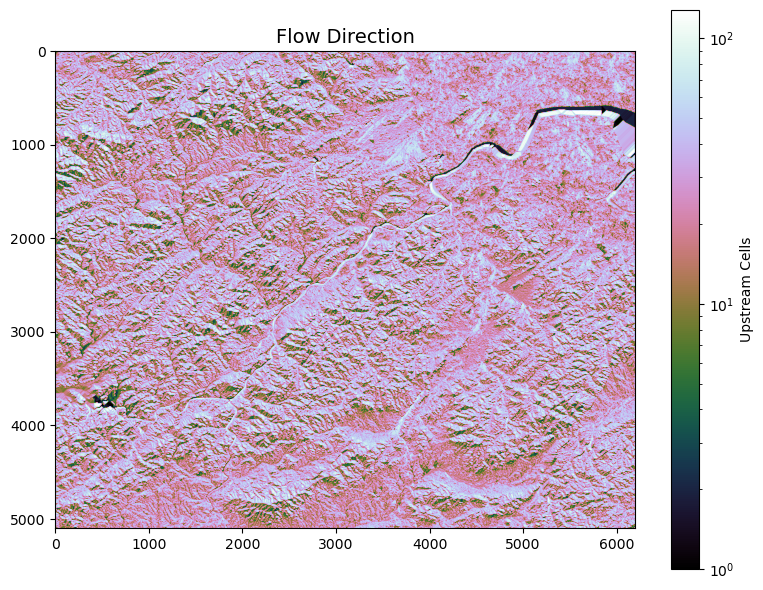

In [4]:
# Compute flow direction based on corrected DEM
fdir = grid.flowdir(inflated_dem)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(fdir, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, fdir.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Direction', size=14)
plt.tight_layout()

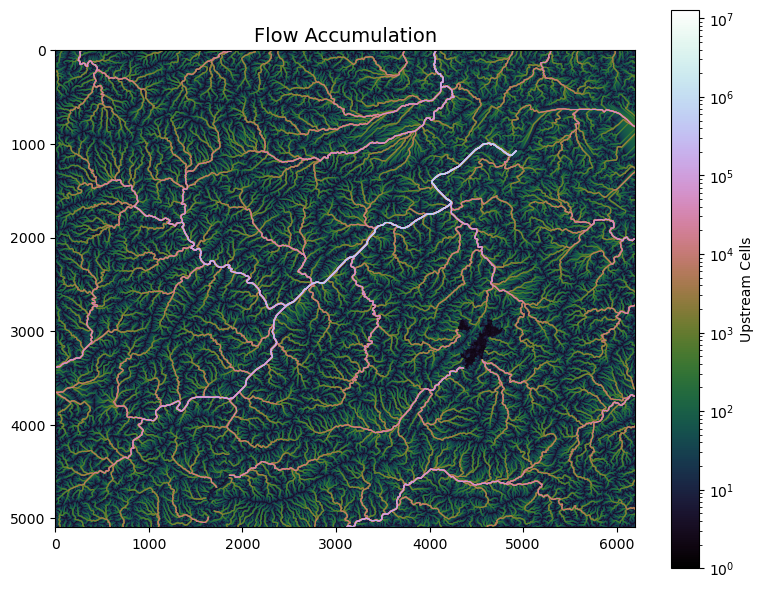

In [5]:
# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(acc, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.tight_layout()

In [6]:
#initial hand
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 500)

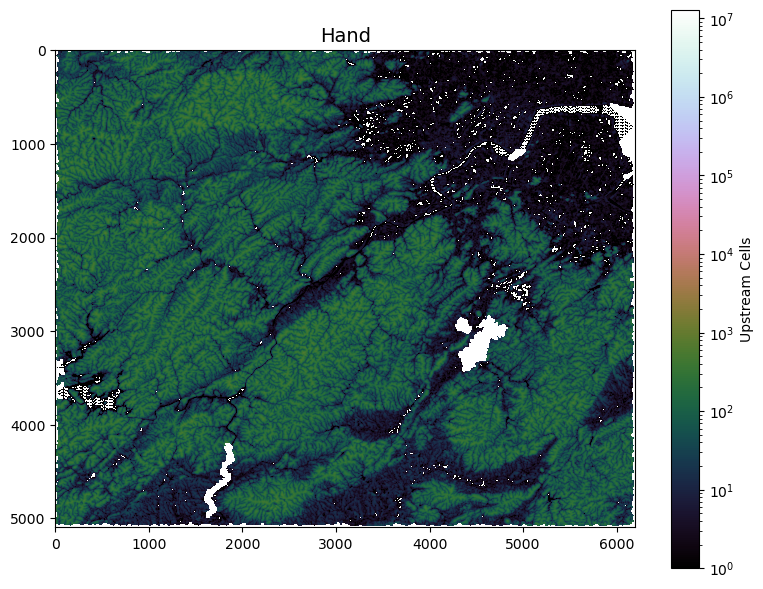

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(hand, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Hand', size=14)
plt.tight_layout()

In [8]:
# add 2023 landuse into consideration

In [9]:
import numpy as np
import rasterio

# 1. Load land cover raster
landcover_path = 'data/inundation/lu2023_clip.tif'
with rasterio.open(landcover_path) as src:
    landcover = src.read(1, masked=True)  # masked array
    landcover_profile = src.profile

# 4. Reclassify land cover
recategorize_map = {
    1: [8, 9, 10],  # Water
    2: [4],         # Grassland
    3: [2, 3],      # Forest
    4: [1, 6],      # Urban
    5: [5, 7]       # Agriculture
}

landcover_recat = np.zeros_like(landcover, dtype=np.uint8)
for new_class, original_classes in recategorize_map.items():
    landcover_recat[np.isin(landcover, original_classes)] = new_class

# 5. Define Percent Impervious
percent_impervious = {
    1: 1.0,   # Water
    2: 0.0,  # Grassland
    3: 0.0,    # Forest
    4: 0.6,  # Urban
    5: 0.0,    # Agriculture
    0: 0.0 # nodata
}

impervious = np.zeros_like(landcover_recat, dtype=np.float32)
for lc_class, imp_value in percent_impervious.items():
    impervious[landcover_recat == lc_class] = imp_value

# 8. Adjust flow accumulation    
adjusted_acc = acc * (1 + impervious)

import numpy as np

min_val = np.nanmin(adjusted_acc)
max_val = np.nanmax(adjusted_acc)
print("adjusted_acc min：", min_val)
print("adjusted_acc max：", max_val)

adjusted_acc min： 1.0
adjusted_acc max： 25839486.0


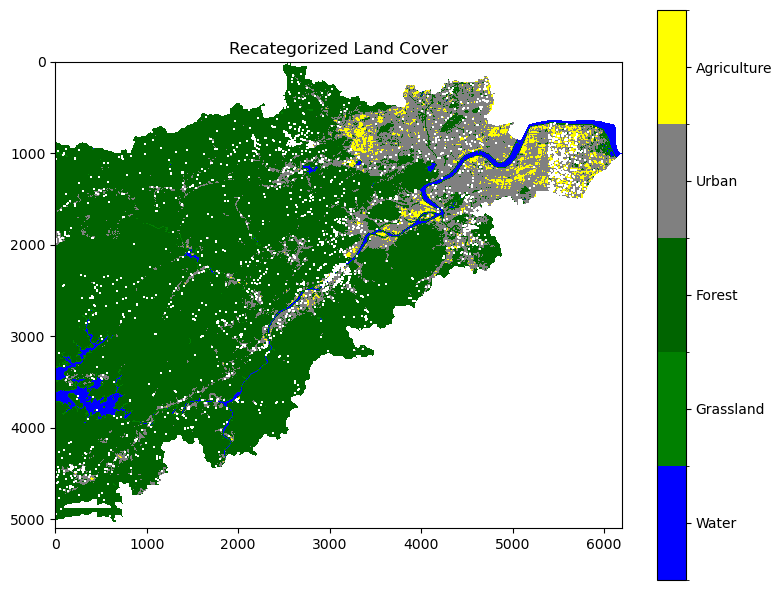

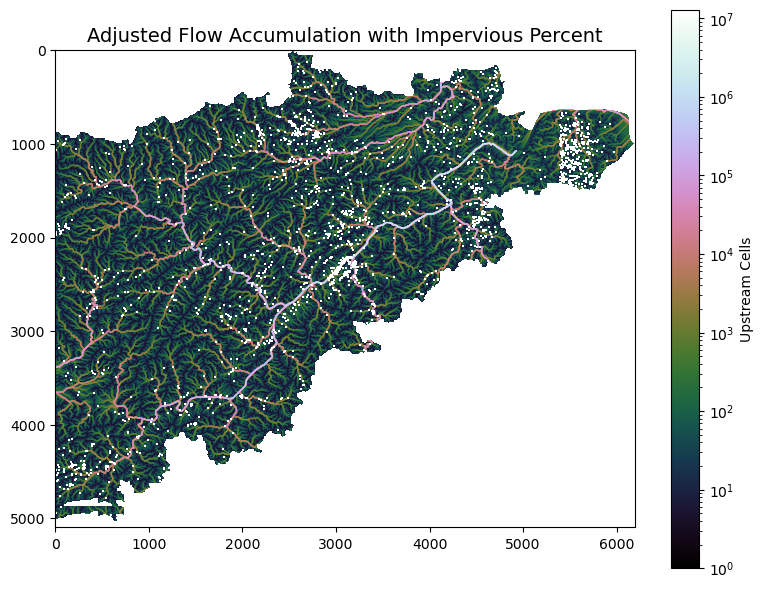

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['blue', 'green', 'darkgreen', 'gray', 'yellow'])
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8,6))
im = plt.imshow(landcover_recat, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['Water', 'Grassland', 'Forest', 'Urban', 'Agriculture'])
plt.title('Recategorized Land Cover')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(adjusted_acc, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Adjusted Flow Accumulation with Impervious Percent', size=14)
plt.tight_layout()

In [11]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

dem_file = 'data/inundation/dem_clip.tif'
with rasterio.open(dem_file) as src:
    meta = src.meta  
    affine = src.transform 
    crs = src.crs  

output_raster = 'data/inundation/adjusted_acc_raster.tif'
with rasterio.open(output_raster, 'w', driver='GTiff', count=1, dtype='float32', 
                   crs=crs, transform=affine, width=adjusted_acc.shape[1], 
                   height=adjusted_acc.shape[0], nodata=0.0) as dst:
    dst.write(adjusted_acc, 1)

print(f"adjusted_acc raster saved as: {output_raster}")

adjusted_acc raster saved as: data/inundation/adjusted_acc_raster.tif


In [12]:
import rasterio
import numpy as np

# Read raw DEM
file = 'data/inundation/adjusted_acc_raster.tif'

grid2 = Grid.from_raster(file)
adjusted_acc = grid2.read_raster(file)

In [13]:
print("Data type of acc:", type(acc))
print("Data type of adjusted_acc:", type(adjusted_acc))

Data type of acc: <class 'pysheds.sview.Raster'>
Data type of adjusted_acc: <class 'pysheds.sview.Raster'>


In [14]:
adjusted_hand = grid.compute_hand(fdir, dem, adjusted_acc > 1000000)
adjusted_hand[adjusted_hand < 0] = 0

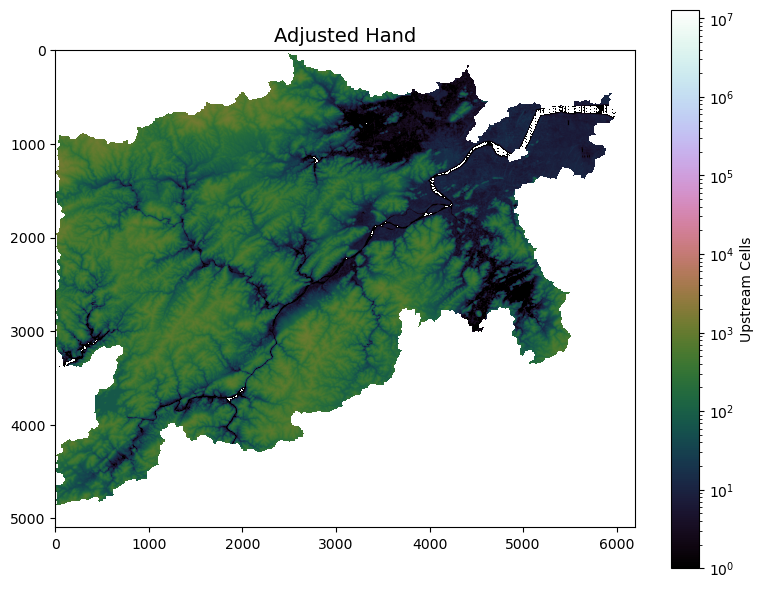

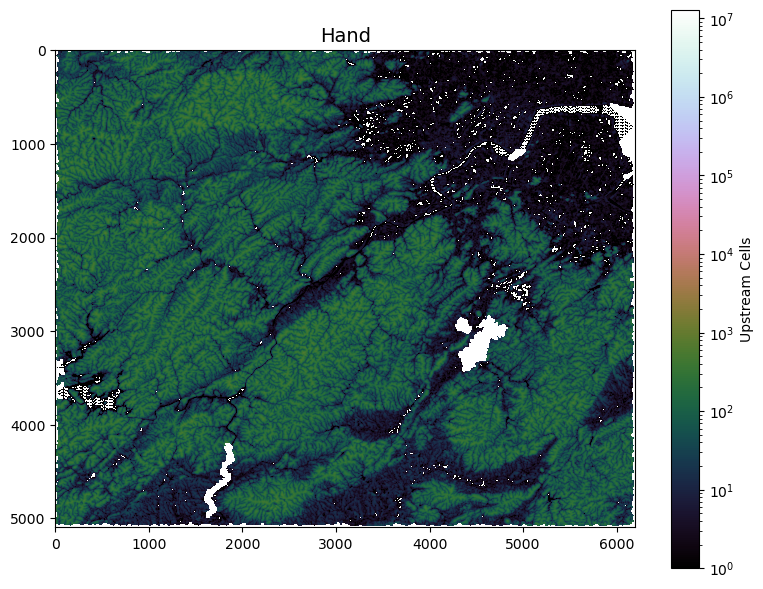

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(adjusted_hand, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Adjusted Hand', size=14)
plt.tight_layout()

# compare with initial hand
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(hand, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Hand', size=14)
plt.tight_layout()

In [16]:
# Clip into AREA and save

In [17]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

boundary = gpd.read_file('data/HZ_Center.shp')

# 打开原始 dem 文件，借用其空间参考信息
with rasterio.open("data/inundation/dem_clip.tif") as src:
    meta = src.meta.copy()
    transform = src.transform

    geoms = boundary.geometry.values
    geoms = [geom.__geo_interface__ for geom in geoms]

    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(**meta) as temp_ds:
            temp_ds.write(adjusted_hand, 1)  # 写入 band 1
            hand_clipped, clipped_transform = mask(temp_ds, geoms, crop=True, filled=True, nodata=-9999)

meta.update({
    "height": hand_clipped.shape[1],
    "width": hand_clipped.shape[2],
    "transform": clipped_transform,
    "nodata": -9999
})

with rasterio.open("data/inundation/hand_final.tif", "w", **meta) as dest:
    dest.write(hand_clipped)

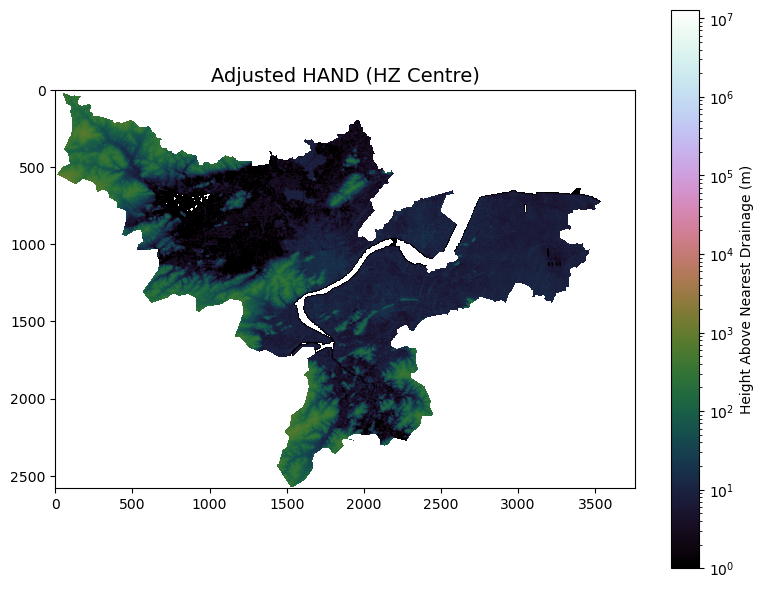

In [21]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib import colors

# 读取 adjusted_hand GeoTIFF
with rasterio.open("data/inundation/hand_final.tif") as src:
    hand_data = src.read(1, masked=True)  # 读取第一波段，自动掩膜 nodata

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

im = ax.imshow(hand_data, cmap='cubehelix',
                norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')

plt.colorbar(im, ax=ax, label='Height Above Nearest Drainage (m)')
plt.title('Adjusted HAND (HZ Centre)', fontsize=14)
plt.tight_layout()
plt.show()

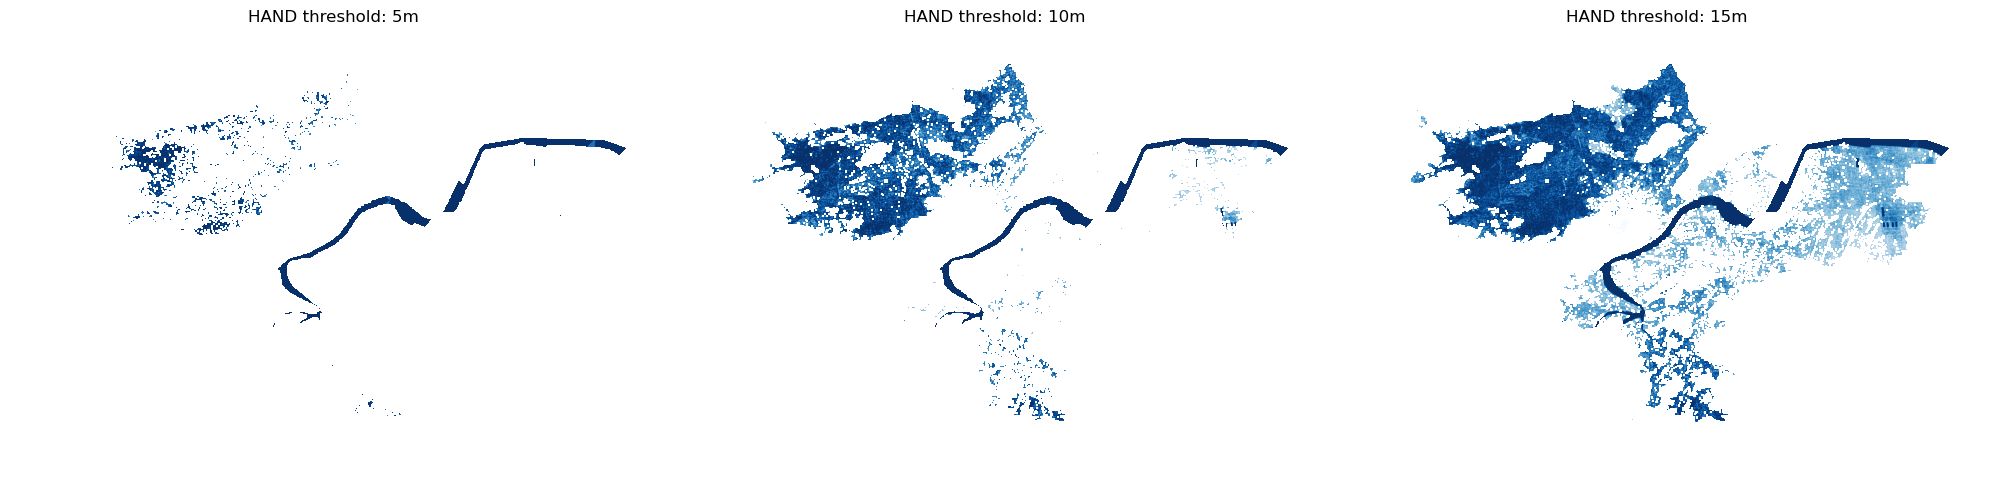

In [19]:
import numpy as np
import rasterio
from rasterio import Affine
import os
import matplotlib.pyplot as plt

hand_path = 'data/inundation/hand_final.tif'
with rasterio.open(hand_path) as src:
    hand = src.read(1)
    profile = src.profile
    nodata = src.nodata
    transform = src.transform

if nodata is not None:
    hand = np.where(hand == nodata, np.nan, hand)

thresholds = [5,10, 15]
fig, axes = plt.subplots(1, len(thresholds), figsize=(20, 5))

for i, t in enumerate(thresholds):
    inundation_extent = np.where(hand < t, t - hand, np.nan)
    img = axes[i].imshow(inundation_extent, cmap='Blues')
    axes[i].set_title(f"HAND threshold: {t}m")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [20]:
output_dir = 'data/inundation'
os.makedirs(output_dir, exist_ok=True)

for t in thresholds:
    inundation_extent = np.where(hand < t, t - hand, np.nan).astype('float32')

    meta = profile.copy()
    meta.update({
        'dtype': 'float32',
        'nodata': np.nan,
        'count': 1
    })

    output_path = os.path.join(output_dir, f'inundation_threshold_{t}m.tif')
    
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(inundation_extent, 1)

print("save!:", output_dir)

save!: data/inundation
